In [1]:
%matplotlib inline
import numpy as np
import qutip as qt

import time

from matplotlib import pyplot as plt

import amolib as alib

In [2]:
plt.style.use('dark_background')
plt.rcParams['font.size'] = 12

# 2-level Atom with QuTip

## Specification of the system:

First define collapse operators.

To do so first define basis states: For an N-dimensional Hilbert space assume that $\psi_k(t) = c_k(t)\vert k\rangle$ and $\vert k\rangle \leftrightarrow (0_0,0_1,\ldots 1_k,\ldots0_{N-1})$

Then the collapse operators are $\sigma_{jk} \equiv \vert j\rangle\langle k\vert \rightarrow c_j(t)c_k(t)^*$. In Qutip these bra/kets ket corresponding to "s = [0,0,...,1,.000]" are written as Qobj(s).

We the write the collapse operators as ket-bras: $\sigma_{jk} \equiv \vert j\rangle\langle k\vert$

... so that we can write operators as: $\hat{A} = \sum_{jk} A_{jk}\sigma_{jk}$

In [3]:
c1 = qt.Qobj([[1],[0]]);c2 = qt.Qobj([[0],[1]])
s11 = c1*c1.trans(); s12 = c1*c2.trans();
s21 = c2*c1.trans(); s22 = c2*c2.trans();

## Representing the Master Equation

Given a Hamiltonian, we can directly write it in terms of collapse operators. 

For example:

$$
\hat{H} = -\begin{pmatrix} \Delta & \Omega \\  \Omega^*& 0\end{pmatrix}
$$

is written as:

$$
H = -\Delta\sigma_{11} - \Omega\sigma_{12} - \Omega^*\sigma_{21}
$$

or:



We then define the Lindblad superoperator on $\hat{A}$ from $\vert j\rangle\rightarrow\vert k\rangle$ as: $\mathcal{L}[\hat{A}] = \gamma(\sigma_{jk}\hat{A}\sigma_{kj} - \frac{1}{2}\sigma_{kk}\hat{A} - \frac{1}{2}\hat{A}\sigma_{kk})$. 

This can be specified via the "spre": $\sigma_{jk}\hat{A}$ and "spost": $\hat{A}\sigma_{jk}$ commands

In [4]:
G = 1 
D = 0.5*G
W = 0.1*G

H = -(D*s11 + W*s12 + np.conj(W)*s21)
L21 = G*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))

M = qt.steadystate(H,[L21])
print('Steady state density matrix:')
print(M)

Steady state density matrix:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.01923077+0.j         -0.09615385+0.09615385j]
 [-0.09615385-0.09615385j  0.98076923+0.j        ]]


## Obtaining steady state spectra

We can obtain steady state solutions to the Master equation with the ''steadystate'' command, which takes a Hamiltonian and list of Lindblad superoperators as an argument.

<code>
    M = steadystate(H,[L21]) # Note L21 must be in a list!
    
</code>


To obtain spectra, we can calculate the steady state solution to the density matrix at each point and use the off-diagonal component of the density matrix:

$$
\chi = \frac{N\vert\mathbf{d}_{12}\vert^2}{\varepsilon_0\hbar}\frac{\rho_{12}}{\Omega}
$$

Note that this equation involves physical parameters such as the dipole moment and number density. There are three approaches to handle this:

 1. Normalize the line-shape by neglecting the physical parameters and work in units of $\Gamma$ (so $\chi = (1 + j\Delta)^{-1}$)
 2. Do not neglect the prefactor but work in convenient units so that, say $\Gamma = 1$.
 3. Actually use the units and deal with small/large numbers. 

When gaining intuition, the first approach is preferred but to make experimental predictions, the third is most clear.

Here we take approach 1 and compare the analytic and numerically computed spectra: 

#### Numerical Spectrum

In [5]:
G = 1 # Normalized linewidth
W = G/10 # Rabi Frequency
Npts = int(8e2) # Number of points in spectra
Dets = np.linspace(-1,1,Npts)*10*G # Define the detunings over which to scan

chi = np.zeros(Npts)*1j # Placeholder for complex susceptibility
for k in range(Npts):
    H = -(Dets[k]*s11 + W*s12 + np.conj(W)*s21) # Define Hamiltonian
    rho = qt.steadystate(H,[L21]) # Steady State solution at this detuning
    chi[k] = rho[0,1]/W # Need to divide by Rabi frequency for susceptibility

#### c.f. Analytic Spectrum

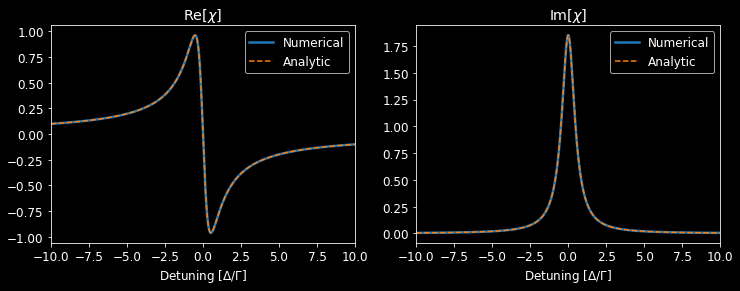

In [6]:
def chi2lev(D,rabi=1,G=1):
    return -(D-1j*G/2)/(D**2 + (G/2)**2 + 2*np.abs(rabi)**2)

fig,(ax1,ax2) = plt.subplots(1,2,figsize = [12,4])

ax1.plot(Dets,np.real(chi),label = 'Numerical',lw =2.5,color = 'tab:blue')
ax2.plot(Dets,np.imag(chi),label = 'Numerical',lw =2.5,color = 'tab:blue')

ax1.plot(Dets,np.real(chi2lev(Dets,rabi=W)),label = 'Analytic',linestyle='--',color = 'tab:orange',lw=1.5)
ax2.plot(Dets,np.imag(chi2lev(Dets,rabi=W)),label = 'Analytic',linestyle='--',color = 'tab:orange',lw=1.5)

ax1.set_xlabel('Detuning [$\Delta/\Gamma$]')
ax1.set_xlim([-10,10])
ax1.set_title('Re[$\chi$]')

ax2.set_xlabel('Detuning [$\Delta/\Gamma$]')
ax2.set_xlim([-10,10])
ax2.set_title('Im[$\chi$]')

ax1.legend()
ax2.legend()

# plt.savefig('qutip_ss2lev.pdf')

## Time Dependance

To obtain a time dependent solution in qutip is super simple. Instead of the <code>steadystate()</code> you use <code>mesolve()</code>.

First you define a time vector over which you wish to solve the equations and then define the collapse and Lindblad operators as before. 

In order to incorporate time dependent Hamiltonians you need to pass the parameters in a funny way. 

First you split $\hat{H}$ into time dependent and time independant parts:

$$
\hat{H}(t) = \hat{H}_0 + \hat{H}_1(t)
$$

Then you further separate $\hat{H}_1$ into a sum of time dependant coefficients:

$$
\hat{H}_1(t) = \sum_kf_k(t)\hat{H}_{1,k}
$$

where the $\hat{H}_{1,k}$ terms are time independent operators. You define the coefficiens via functions:
<code>
    def fa(t):
        # ....
</code>

Finally, you pass these into the mesolve function via:

<code>
    H = [H0,[H1a,f1a],...,[H1k,f1k],t,[La,Lb,...],[s11,s12,...]]
</code>

The last argument is the desired expection values you want as a function of time.

Below we do this for the simple case of the 2-level atom. Here 

$$
\hat{H}_0 = -\Delta\hat{\sigma}_{11}
$$

and

$$
\hat{H}_1 = -\Omega(t)\times\left(\hat{\sigma}_{12} + \hat{\sigma}_{21}\right)
$$

We compare this to the steady state solution and plot the results:

In [57]:
# Atomic Parameters
G = 1 
D = 0.65*G
W = 5*G
Nt = int(2e3)

# Normal Lindbladian
L21 = G*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))

# Define time Vector
t = np.linspace(0,1,Nt)*35/G

# Initial condition
rho0 = s22

# Define time Dependant coefficients
def pulse(t,tp = 'step'):
    global G, W
    return W*(t > 2.5/G)*(t<18/G)

# Construct Hamiltonian
H0 = -D*s11
H1 = -(s12+s21) # Muliplied by W(t)
H = [H0,[H1,pulse]]

# ... and solve
result = qt.mesolve(H, rho0,t,[L21],[s11,s21])

# We can also compute the corresponding steady state solution for comparison
H_static = H0 + W*H1
result_static = qt.steadystate(H_static,[L21])
t = result.times
pop = result.expect[0]
chi = result.expect[1]/W

pop_ss = np.ones(len(t))*result_static[0,0]
chi_ss = (0j+np.ones(len(t)))*result_static[0,1]/W

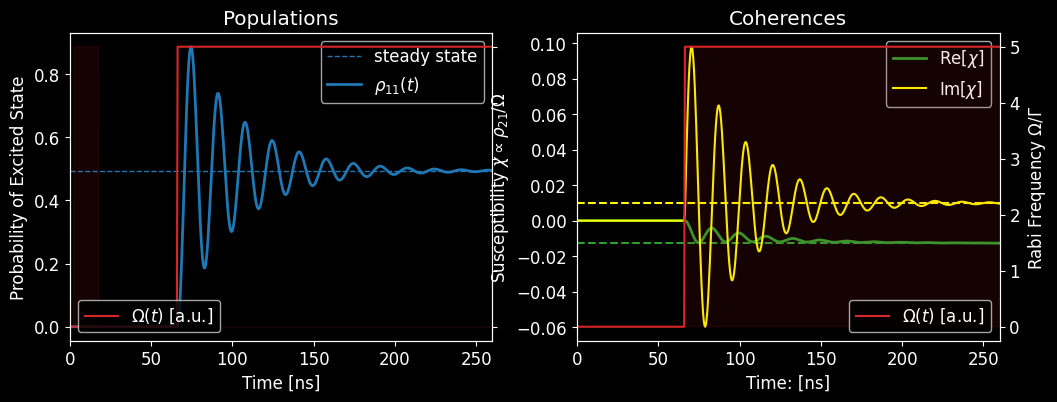

In [25]:
# Make a purdy plot...
t_ns = 26.52*t

fig,(ax1,ax2) = plt.subplots(1,2,figsize = [12,4])

ax1.plot(t_ns,np.real(pop_ss),'--',color = 'tab:blue',lw=1,label = 'steady state')
ax1.plot(t_ns,pop,'-',color = 'tab:blue',lw=2,label = '$\\rho_{11}(t)$')
ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax1a.fill_between(t_ns,pulse(t_ns),color = 'tab:red',alpha=.1)


ax1a.plot(t_ns,pulse(t),color = 'tab:red',label='$\Omega(t)$ [a.u.]')

ax2.plot(t_ns,np.real(chi_ss),'--',color = 'tab:green')
ax2.plot(t_ns,np.real(chi),label='Re[$\chi$]',color = 'tab:green',lw =2)
ax2.plot(t_ns,np.imag(chi_ss),'--',color = 'yellow')
ax2.plot(t_ns,np.imag(chi),label='Im[$\chi$]',color = 'yellow')
ax2a.fill_between(t_ns,pulse(t),color = 'tab:red',alpha=.1)
ax2a.plot(t_ns,pulse(t),color = 'tab:red',label='$\Omega(t)$ [a.u.]')

ax1a.legend(loc=3)
ax1.legend()
ax2.legend()
ax2a.legend(loc = 4)

ax1.set_title('Populations')
ax2.set_title('Coherences')

ax1a.yaxis.set_ticklabels([]);
# ax2.yaxis.set_ticklabels([]);

ax1.set_ylabel('Probability of Excited State')
ax1.set_xlabel('Time [ns]')
ax2.set_ylabel('Susceptibility $\chi \propto \\rho_{21}/\Omega$')
ax2.set_xlabel('Time: [ns]')
ax2a.set_ylabel('Rabi Frequency $\Omega/\Gamma$')

ax1.set_xlim(0,260)
ax2.set_xlim(0,260);

## Realistic Spectra: Doppler and Units

We'd like to simulate the absorption and phase we'd get in the lab. The two challenges are:

1. Getting realistic Units right

2. Including Doppler Broadening

### Getting the units right

From above, the susceptibility is related to the density matrix via:
$$
\chi = \frac{N\vert d\vert^2}{\varepsilon_0 \hbar\Omega}\rho_{21}
$$

Note that $N$ is the number **density** having units of $m^{-3}$. Knowing the number of atoms in a cold atomic cloud this can be directly written. In a Thermal vapour cell however, this number density is a funtion of temperature which dictate the vapour pressure in thermal equilibrium via the Claussius-Clapeyron equation. In Thermal equilibrium this is for $^{87}$Rb:


\begin{align}
\log_{10} P_v &= −94.04826 −\frac{1961.258}{T} − 0.03771687T + 42.57526\log_{10}T &\ldots \text{(solid phase)} \\
\log_{10} P_v &= −94.04826 −\frac{15.882 53 }{T} − 0.00058663T + 2.99138\log_{10}T &\ldots \text{(liquid phase)}
\end{align}

The dipole moment $d$ of Rb is not constant but depends on the optical polarization, transistion strength, and detuning. It is on the order of a few $ea_0 \approx 2\times10^{-29}~\text{C}\cdot\text{m}$

The Rabi frequency $\Omega$ can be related to the intensity via: $I=\frac{1}{2}\varepsilon_0c^2\vert E\vert^2$ and $\Omega = \frac{\mathbf{d}\cdot\mathbf{E}}{\hbar}$. More commonly, the optical power isn a roughly circular beam is specified: $P_{opt} = \pi w_0^2 I$, giving:

$$
\Omega = \sqrt{\frac{2d^2 P_{opt}}{\varepsilon c\hbar^2\pi w_0^2}}
$$

The absorption is then given by Beer's law:

$$
\frac{P(z)}{P_0} = \exp\left[-\frac{\pi}{\lambda}\chi_Iz\right] = e^{-\alpha z}
$$

For normal numbers, this leads to an extremely large resonant optical depth even at room temperature. For example at $300$K, $N(T) \approx 10^{16}~\text{m}^{-3}$ so that $\frac{N\vert d\vert^2}{\varepsilon_0 \hbar}\approx 10^4$.

For low intensities, $\chi$ is approximately independent of $\Omega$ and is given by $\chi = i\frac{2}{\Gamma}\times\frac{N\vert d\vert^2}{\varepsilon_0 \hbar}$. With $\Gamma_{Rb} \approx 2\pi\times 6~$MHz,and $\lambda \approx 8\times10^{-7}$m this gives an optical depth of $\alpha \approx 220000~\text{m}^{-1}$ - an insanely high optical depth.

This optical depth is not normally seen in the lab however, because to achieve this number density, thermal vapours are required and in these vapours, Doppler broadening spreads this absorption over many frequencies, significantly reducing the optical depth. 

### Including Doppler Broadening

An laser source moving toward a stationary atom will appear Doppler shifted to a higher frequency and so resonance will occur at a lower frequency than expected in the lab frame. Since Thermal motion at temperature $T$ leads to the population of atoms being distributed according a Maxwellian spread in velocity. Each group of atoms with a particular velocity will appear to have a shifted resoanant frequency according to the Doppler effect. The atoms are thus distributed according to:

$$
N(T)d\nu = \frac{N_{\nu}}{\sqrt{2\pi\sigma_D^2}}\exp\left[-\left(\frac{\nu}{\sqrt{2}\sigma_D}\right)^2\right]d\nu
$$

Here $N_\nu$ is the vapour pressure from above and the Doppler width is given in angular frequency by:

$$
\sigma_D(T) = 2\pi\times\sqrt{\frac{k_BT}{m_{Rb}\lambda_0^2}}
$$

Note that different transitions and isotopes have slightly different widths, but this is minimal with $^{87}$Rb at D1 having $\sigma_D = 2\pi\times 212.9$ MHz and $^{85}$Rb at D1 having $\sigma_D = 2\pi\times 219.5$ MHz.

Thus in an experiment, at each *laser detuning* the absorption will be due to a spread in apparent resonant frequencies. We then must integrate the susceptibility at a given point over all doppler shifts!

The Doppler broadented spectrum is thus calculated via:

$$
\chi_D(\Delta) =  \frac{N_{\nu}}{\sqrt{2\pi\sigma_D^2}}\int_{-\infty}^\infty\chi(\Delta-\nu)e^{-\frac{\nu^2}{2\sigma_D^2}}d\nu
$$

Where $\chi(\Delta)$ is the single atom susceptibility.

Note that for this simple case of a single transition, this is merely the convolution of the susceptibilty with the Normal distribution, which can be calculated efficiently via the convolution theorem:

$$
\chi_D(\Delta) =  N\left[\chi*P_D\right](\Delta) = \mathcal{F}^{-1}\left[\mathcal{F}\left(\chi\right)\mathcal{F}\left(P_D\right)\right]
$$

Caution is to be taken here since, for systems with multiple fields **will not generally be** the $N$-Dimensional convolution:

$$
\chi_D(\Delta_1,\Delta_2,\ldots) =  \frac{N_{\nu}}{\sqrt{2\pi\sigma_D^2}}\int_{-\infty}^\infty\chi(\Delta_1-\nu,\Delta_2-\nu,\ldots)e^{-\frac{\nu^2}{2\sigma_D^2}}d\nu \ne  N\left[\chi*P_D\right](\Delta)
$$

In this case, the full integration must be performed (*I think!!!*)

#### Let's start by simulating Doppler broadening with unscaled susceptibility:

Psuedo-code;
<code>
    define all parameters and collapse operators
    define range of interest
    for each detuning in spectrum
        compute spectra shifted by doppler
        numerically integrate: trapz(spect_shifted,doppler)
        set density matrix element at this detuning to this value
</code>

In [9]:
# First, define a function for QuTip to calculate a spectrum at a given set of parameters
def get_chi2lev(frk,Rabi=1e-8,prefactor=1,Gamma = 1):
    chi0 = np.zeros(len(frk))*1j
    for k in range(len(frk)):
        L21 = Gamma*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))
        H = -((frk[k])*s11 + Rabi*s12 + np.conj(Rabi)*s21)
        rho_ss = qt.steadystate(H,[L21])
        chi0[k] = prefactor*rho_ss[0,1]/Rabi
    return chi0

computed 4000 points in 9.9 s


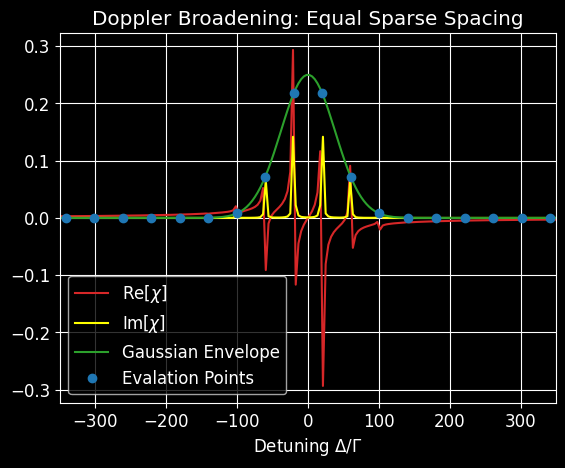

In [ ]:
stort = time.time()

G = 1 # Normalized linewidth
W = G/10 # Rabi Frequency
Nspect = int(2e2) # Number of points in spectrum
Ndop = 20#int(5e1)
T = 300
mRb,lmd = alib.amu*85, alib.lambdaRb87_D2

sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))
sD/= alib.GammaRb

Dets = np.linspace(-1,1,Nspect)*10*sD # Define the detunings over which to scan
Dops = np.linspace(-1,1,Ndop)*10*sD

Pd = np.exp(-0.5*(Dops/sD)**2)/np.sqrt(2*np.pi*sD**2)

chiD = np.zeros(Nspect)*1j # Placeholder for complex susceptibility
chi = np.zeros(Ndop)*1j

for k in range(Nspect):
    chi = get_chi2lev(Dets[k]-Dops,Rabi = W)
    chiD[k] = np.trapz(chi*Pd,Dops)
    
tim = time.time()-stort

print(f'computed {Ndop*Nspect} points in {round(tim,1)} s')
fig,ax = plt.subplots()
ax.plot(Dets,np.real(chiD),color = 'tab:red',label = 'Re[$\chi$]')
ax.plot(Dets,np.imag(chiD),color = 'yellow',label = 'Im[$\chi$]')
ax.plot(Dets,0.25*np.exp(-.5*(Dets/sD)**2),color = 'tab:green',label = 'Gaussian Envelope')
ax.plot(Dops,0.25*np.exp(-.5*(Dops/sD)**2),'o',color = 'tab:blue',label = 'Evalation Points')
ax.set_xlim(-350,350)
ax.grid(True)
ax.legend()
ax.set_title('Doppler Broadening: Equal Sparse Spacing')
ax.set_xlabel('Detuning $\\Delta/\Gamma$');
# plt.savefig('../../Notes/Images/2023/SparseGauss.png')

computed 400000 points in 688.7 s


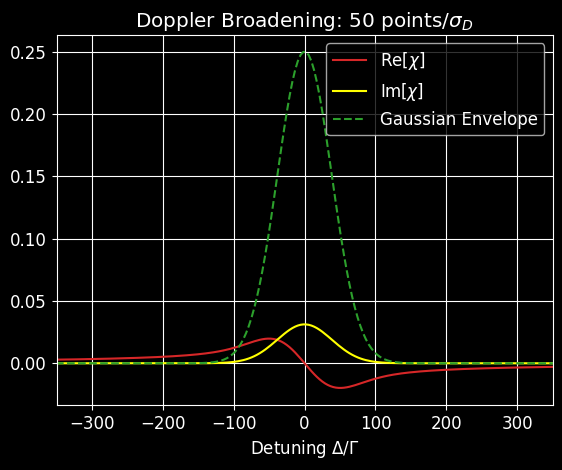

In [ ]:
stort = time.time()

G = 1 # Normalized linewidth
W = G/10 # Rabi Frequency
Nspect = int(2e2) # Number of points in spectrum
Ndop = int(2e3)
T = 300
mRb,lmd = alib.amu*85, alib.lambdaRb87_D2

sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))
sD/= alib.GammaRb

Dets = np.linspace(-1,1,Nspect)*10*sD # Define the detunings over which to scan
Dops = np.linspace(-1,1,Ndop)*10*sD

Pd = np.exp(-0.5*(Dops/sD)**2)/np.sqrt(2*np.pi*sD**2)

chiD = np.zeros(Nspect)*1j # Placeholder for complex susceptibility
chi = np.zeros(Ndop)*1j

for k in range(Nspect):
    chiD[k] = np.trapz(get_chi2lev(Dets[k]-Dops,Rabi=W)*Pd,Dops)
    
tim = time.time()-stort

print(f'computed {Ndop*Nspect} points in {round(tim,1)} s')
fig,ax = plt.subplots()
ax.plot(Dets,np.real(chiD),color = 'tab:red',label = 'Re[$\chi$]')
ax.plot(Dets,np.imag(chiD),color = 'yellow',label = 'Im[$\chi$]')
ax.plot(Dets,0.25*np.exp(-.5*(Dets/sD)**2),'--',color = 'tab:green',label = 'Gaussian Envelope')
# ax.plot(Dops,0.25*np.exp(-.5*(Dops/sD)**2),'o',color = 'tab:blue',label = 'Evalation Points')
ax.set_xlim(-350,350)
ax.grid(True)
ax.legend()
ax.set_title('Doppler Broadening: 50 points/$\\sigma_D$')
ax.set_xlabel('Detuning $\\Delta/\Gamma$');
# plt.savefig('../../Notes/Images/2023/SparseGauss250.png')

# Windows box, Anaconda 3.9
## computed 100000 points in 176.9 s

# Macbook, Visual Studio Python 3.11
## computed 100000 points in 335.3 s

computed 400000 points in 56.0 s


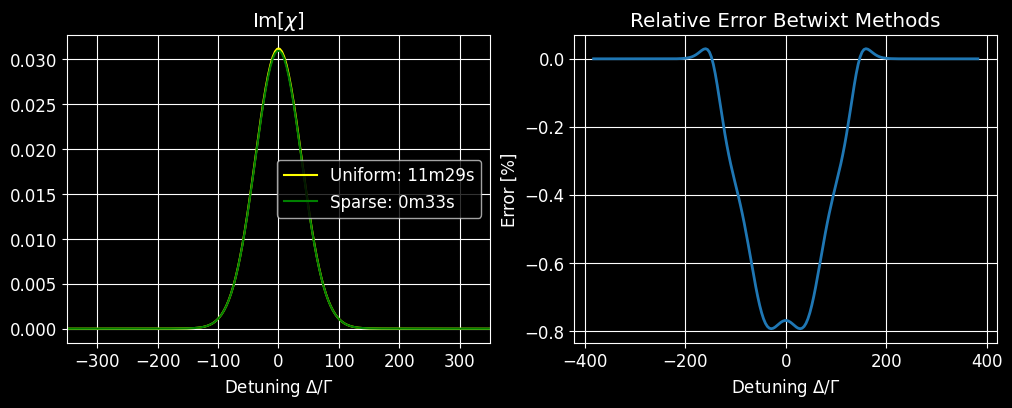

In [ ]:
stort = time.time()

G = 1 # Normalized linewidth
W = G/10 # Rabi Frequency
Nspect = int(2e2) # Number of points in spectrum

NSparse = 45
NDense = 10
NDop = 2*NSparse + NDense

T = 300
mRb,lmd = alib.amu*85, alib.lambdaRb87_D2

sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))
sD/= alib.GammaRb


Dets = np.linspace(-1,1,Nspect)*10*sD # Define the detunings over which to scan
chiD_nus = np.zeros(Nspect)*1j # Placeholder for complex susceptibility

for k in range(Nspect):
    Dops = np.linspace(-10*sD,Dets[k]-4*G,NSparse)
    Dops = np.append(Dops, np.linspace(Dets[k]-4*G,Dets[k]+4*G,NDense))
    Dops = np.append(Dops,np.linspace(Dets[k]+4*G,10*sD,NSparse))
    Pd = np.exp(-0.5*(Dops/sD)**2)/np.sqrt(2*np.pi*sD**2)
    chiD_nus[k] = np.trapz(get_chi2lev(Dets[k]-Dops,Rabi=W)*Pd,Dops)
    
# tim = time.time()-stort

print(f'computed {Ndop*Nspect} points in {round(tim,1)} s')
fig,(ax1,ax2) = plt.subplots(1,2,figsize = [12,4])
# ax.plot(Dets,np.real(chiD),color = 'tab:red',label = 'Re[$\chi$]')
ax1.plot(Dets,np.imag(chiD),color = 'yellow',label = 'Uniform: 11m29s')
ax1.plot(Dets,np.imag(chiD_nus),color = 'green',label = 'Sparse: 0m33s')
ax1.set_xlim(-350,350)
ax1.grid(True)
ax1.legend()
ax1.set_title('Im[$\chi$]')
ax1.set_xlabel('Detuning $\\Delta/\Gamma$')
# plt.savefig('../../Notes/Images/2023/SparseGauss250.png')
ax2.plot(Dets,100*(np.imag(chiD_nus)-np.imag(chiD))/np.imag(chiD),lw = 2,color = 'tab:blue')
ax2.set_ylabel('Error [%]')
ax2.set_xlabel('Detuning $\\Delta/\Gamma$')
ax2.set_title('Relative Error Betwixt Methods')
ax2.grid(True)

# plt.savefig('../../Notes/Images/2023/Sparse_vs_Dense.png')

## Now look at real units and realistic experimental parameters

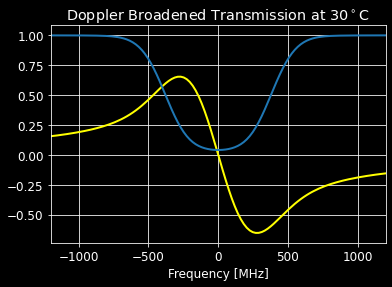

In [88]:
T = 273 + 30
Lcell = 25e-3

lmd = alib.lambdaRb87_D1

N = alib.getNRb(T)
d = alib.dRb
e0 = alib.epsilon0
hb = alib.hbar
G = alib.GammaRb
mRb = alib.amu*87
kz = 2*np.pi*Lcell/lmd

sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))

Wr = 0.0001*G

scl = (N*d**2)/(hb*e0)


Nspect = int(2e2) # Number of points in spectrum

NSparse = 45
NDense = 10
NDop = 2*NSparse + NDense

# np.imag(get_chi2lev([0],Rabi=Wr,prefactor=scl,Gamma = G))[0]*kz

Dets = np.linspace(-1,1,Nspect)*10*sD # Define the detunings over which to scan
chi = np.zeros(Nspect)*1j # Placeholder for complex susceptibility

stort = time.time()
for k in range(Nspect):
    Dops = np.linspace(-10*sD,Dets[k]-4*G,NSparse)
    Dops = np.append(Dops, np.linspace(Dets[k]-4*G,Dets[k]+4*G,NDense))
    Dops = np.append(Dops,np.linspace(Dets[k]+4*G,10*sD,NSparse))
    Pd = np.exp(-0.5*(Dops/sD)**2)/np.sqrt(2*np.pi*sD**2)
    chi[k] = np.trapz(get_chi2lev(Dets[k]-Dops,Rabi=Wr,prefactor = scl, Gamma = G)*Pd,Dops)
tim = time.time()-stort
print(f'computed {NDop*Nspect} points in {round(tim,1)} s')

fig,ax = plt.subplots()

ax.plot(Dets/(2*np.pi*1e6),kz*np.real(chi)/(np.pi),lw = 2,color = 'yellow')
ax.plot(Dets/(2*np.pi*1e6),np.exp(-kz*np.imag(chi)),lw = 2,color = 'tab:blue')
ax.set_xlim(-1200,1200)
ax.set_xlabel('Frequency [MHz]')
# ax.set_ylabel('Transmission')
ax.set_title(f'Doppler Broadened Transmission at {T-273}$^\circ$C')
ax.grid()
# plt.savefig('../../Notes/Images/2023/DoppBroadUnits.png')

## Time Dependance in a Thermally Broadened Medium

OK you can efficiently incorporate Doppler Broadining and solve wih real units for the spectra. 

Since each atomic velocity class should be independent, we can use a statistical average. The idea is then to calculate the response for each Doppler detuning and then perform a weighted average according to the Doppler distribution.

In [228]:
T = 273 + 30
Lcell = 25e-3

lmd = alib.lambdaRb87_D1

N = alib.getNRb(T)
d = alib.dRb
e0 = alib.epsilon0
hb = alib.hbar
G = alib.GammaRb
mRb = alib.amu*87
kz = 2*np.pi*Lcell/lmd

sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))

Wr = 0.001*G

scl = (N*d**2)/(hb*e0)

Det = sD

NSparse = 45
NDense = 10
NDop = 2*NSparse + NDense
sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))
Dops = np.linspace(-10*sD,Det-4*G,NSparse)
Dops = np.append(Dops, np.linspace(Det-4*G,Det+4*G,NDense))
Dops = np.append(Dops,np.linspace(Det+4*G,10*sD,NSparse))

Pd = np.exp(-0.5*(Dops/sD)**2)/np.sqrt(2*np.pi*sD**2)

Nt = int(2e3)

# Normal Lindbladian
L21 = G*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))

# Define time Vector
t = np.linspace(0,1,Nt)*35/G

# Initial condition
rho0 = s22

# Define time Dependant coefficients
def pulse(t,tp = 'rampon'):
    global G, Wr
    if tp =='step':
        return Wr*(t > 2.5/G)*(t<18/G)
    else:
        return Wr/(1+np.exp(-G*(t-5/G)/.5))

# Construct Hamiltonian
p11 = np.zeros((Nt,NDop))+0j
p12 = np.zeros((Nt,NDop))+0j

# Dops = np.arange(-5,5.1)*G
stort = time.time()
for k in range(len(Dops)):
    H0 = -(Det-Dops[k])*s11
    H1 = -(s12+s21) # Muliplied by W(t)
    H = [H0,[H1,pulse]]
    result = qt.mesolve(H, rho0,t,[L21],[s11,s21]) 
    p11[:,k] = result.expect[0]
    p12[:,k] = result.expect[1]    
tim = time.time()-stort
print(f'Computation time: {round(tim,2)}s')

# # for k in range(NDop):
# #     H0 = -(Det-Dops[k])*s11
# #     H1 = -(s12+s21) # Muliplied by W(t)
# #     H = [H0,[H1,pulse]]
# #     result = qt.mesolve(H, rho0,t,[L21],[s11,s21])
# #     pop[:,k] += result.expect[0]
# #     sus[:,k] += result.expect[1]/W

# # pops = np.trapz(pop*Pd,Dops)
# # susc = np.trapz(sus*Pd,Dops)

# # # ... and solve


# # # We can also compute the corresponding steady state solution for comparison
# # H_static = H0 + W*H10
# # result_static = qt.steadystate(H_static,[L21])
# # t = result.times
# # pop = result.expect[0]
# # chi = result.expect[1]/W

# pop_ss = np.ones(len(t))*result_static[0,0]
# chi_ss = (0j+np.ones(len(t)))*result_static[0,1]/W

Computation time: 10.47s


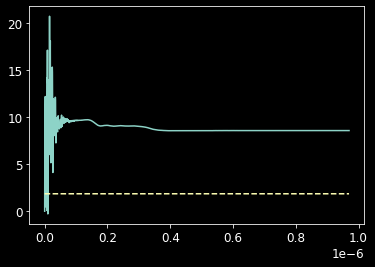

In [229]:
pop = np.zeros(Nt)
sus = np.zeros(Nt)+0j
for k in range(Nt):
    pop[k] = np.real(np.trapz(Pd*p11[k,:],Dops))
    sus[k] = np.trapz(Pd*p12[k,:],Dops)
sus*= PF*kz/pulse(t)
fig,ax = plt.subplots()
# ax.plot(t,np.real(sus))

ss_val = np.imag(kz*chi[np.argwhere(Dets >= Det)[0]])

ax.plot(t,np.imag(sus))
ax.plot(t,t*0 + ss_val,'--')



# ax.plot(t,pop)

(0.0, 1e-07)

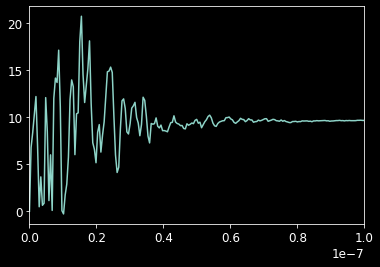

In [231]:
fig,ax = plt.subplots()
ax.plot(t,np.imag(sus))
ax.set_xlim(0,1e-7)

In [49]:
T = 273 + 30
Lcell = 25e-3

lmd = alib.lambdaRb87_D1

N = alib.getNRb(T)
d = alib.dRb
e0 = alib.epsilon0
hb = alib.hbar
G = alib.GammaRb
mRb = alib.amu*87
kz = 2*np.pi*Lcell/lmd

sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))

Wr = 0.0001*G

scl = (N*d**2)/(hb*e0)

def pulse(t,ramp_type = 'sigmoid'):
    global G, Wr
    if ramp_type =='step':
        return Wr*(t > 2.5/G)*(t<18/G)
    elif ramp_type == 'sigmoid':
        return Wr/(1+np.exp(-G*(t-2.5/G)/.1))
    else:
        return Wr*np.exp(-0.5*((t-7)/1)**2)

## Investigate numerical instability

First, it was noticed that the oscillations may have been due to a sigmoid function. 

However upon careful rewriting, I can not reproduce this bug.

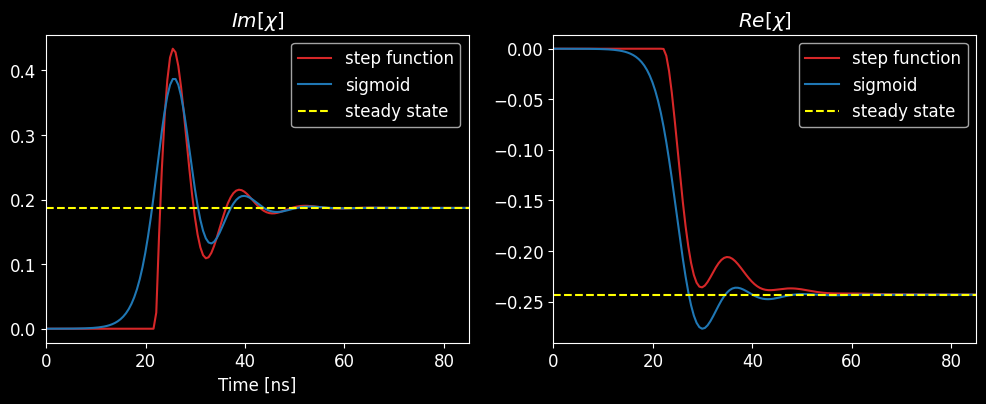

In [69]:
# Atomic Parameters
G = 1
D = 0.65*G
Wr = 1*G
Nt = int(2e2)

t_on = 5
sig_wd = 0.5

# Normal Lindbladian
L21 = G*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))

# Define time Vector
t = np.linspace(0,1,Nt)*25/G

# Initial condition
rho0 = s22

# STEADY STATE
H = -(D*s11 + Wr*s12 + np.conj(Wr)*s21)
rho_ss = qt.steadystate(H,[L21])
chi_ss = np.ones(len(t))*rho_ss[0,1]/Wr

# STEP FUNCTION
def pulse(t,dummy=False):
    global G, Wr
    return Wr*(t > t_on/G)

# Construct Hamiltonian
H0 = -D*s11
H1 = -(s12+s21) # Muliplied by W(t)
H = [H0,[H1,pulse]]

# # ... and solve
result_stp = qt.mesolve(H, rho0,t,[L21],[s11,s21])

pop_stp = result_stp.expect[0]
chi_stp = result_stp.expect[1]/Wr
t_stp = result_stp.times

# SIGMOID FUNCTION
def pulse(t,dummy=False):
    global G, Wr
    return Wr*1/(1+np.exp(-G*(t-t_on/G)/sig_wd))

# Construct Hamiltonian
H0 = -D*s11
H1 = -(s12+s21) # Muliplied by W(t)
H = [H0,[H1,pulse]]

# # ... and solve
result_sig = qt.mesolve(H, rho0,t,[L21],[s11,s21])

pop_sig = result_sig.expect[0]
chi_sig = result_sig.expect[1]/Wr
t_sig = result_sig.times

t_scl = 1e9/(2*np.pi*alib.GammaRb)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=[12,4])

ax1.plot(t_scl*t_stp,np.imag(chi_stp),label = 'step function',color = 'tab:red')
ax1.plot(t_scl*t_sig,np.imag(chi_sig),label = 'sigmoid',color = 'tab:blue')
ax1.plot(t_scl*t,np.imag(chi_ss),'--',label = 'steady state',color = 'yellow')

ax2.plot(t_scl*t_stp,np.real(chi_stp),label = 'step function',color = 'tab:red')
ax2.plot(t_scl*t_sig,np.real(chi_sig),label = 'sigmoid',color = 'tab:blue')
ax2.plot(t_scl*t,np.real(chi_ss),'--',label = 'steady state',color = 'yellow')

ax1.set_title('$Im[\chi]$')
ax2.set_title('$Re[\chi]$')

ax1.legend()
ax2.legend()

ax1.set_xlim([0,85])
ax2.set_xlim([0,85])

ax1.set_xlabel('Time [ns]')
fig.savefig('../../Notes/Images/2023/step_v_sigmoid.png',bbox_inches = 'tight')

### Multiple detunings

Next Hypothesis is that there is effectively random sampling from the various detunings ... but the averaging seems to lead to a rather smooth result

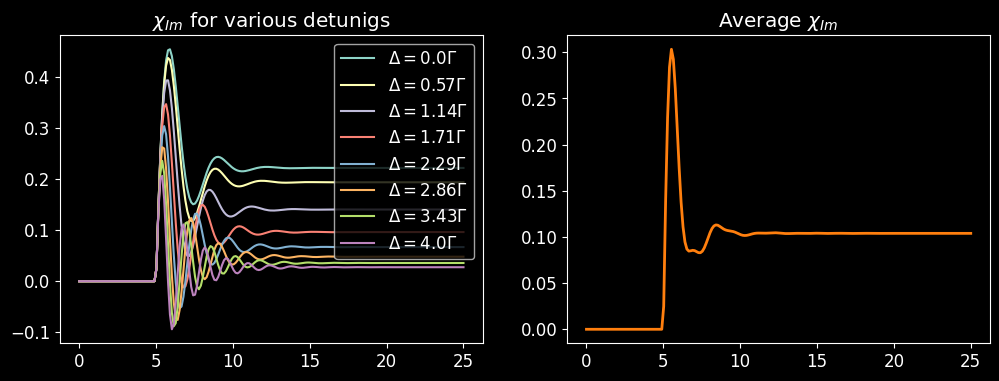

In [71]:
# Atomic Parameters

NumDets = 8
G = 1
Detlef = np.linspace(0,4,NumDets)*G
Wr = 1*G
Nt = int(2e2)

t_on = 5
sig_wd = 0.5

# Normal Lindbladian
L21 = G*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))

# Define time Vector
t = np.linspace(0,1,Nt)*25/G

# Initial condition
rho0 = s22

def pulse(t,dummy=False):
    global G, Wr
    return Wr*(t > t_on/G)

fig,(ax1,ax2) = plt.subplots(1,2,figsize = [12,4])

chi_avg = np.zeros(Nt)

for k in range(len(Detlef)):
    H0 = -Detlef[k]*s11
    H1 = -(s12+s21) # Muliplied by W(t)
    H = [H0,[H1,pulse]]
    result = qt.mesolve(H, rho0,t,[L21],[s11,s21])
    kim_chi = np.imag(result.expect[1]/Wr)
    chi_avg += kim_chi
    ax1.plot(result.times,kim_chi,label = '$\Delta = $'+str(round(Detlef[k],2))+'$\Gamma$')
ax2.plot(t,chi_avg/len(Detlef),lw=2,color = 'tab:orange')
ax2.set_title('Average $\chi_{Im}$')
ax1.legend(loc = 1)
ax1.set_title('$\chi_{Im}$ for various detunigs')

# fig.savefig('../../Notes/Images/2023/multi_dop.png',bbox_inches = 'tight')

### Doppler Broadened time depandant response

In [11]:
G = 1
Wr = 1*G
Nt = int(2e2)
# Define time Vector
t = np.linspace(0,1,Nt)*25/G

chi_1e4 = np.zeros(Nt)
t_1e4 = t

t_on = 5
sig_wd = 0.5

NSparse = 4000
NDense = 1000
NDop = (2*NSparse + NDense)

T = 300
mRb,lmd = alib.amu*85, alib.lambdaRb87_D2

sD = 2*np.pi*np.sqrt(alib.kB*T/(mRb*lmd**2))/alib.GammaRb

Det = 2*G

rho0 = s22

# Normal Lindbladian
L21 = G*(qt.spre(s21)*qt.spost(s12) - 0.5*qt.spre(s11) - 0.5*qt.spost(s11))


Dops = np.linspace(-10*sD,Det-4*G,NSparse)
Dops = np.append(Dops, np.linspace(Det-4*G,Det+4*G,NDense))
Dops = np.append(Dops,np.linspace(Det+4*G,10*sD,NSparse))

chi_lst = np.zeros([Nt,NDop])

def pulse(t,dummy=False):
    global G, Wr
    return Wr*(t > t_on/G)

stort = time.time()
for k in range(NDop):
    H0 = -(Det-Dops[k])*s11
    H1 = -(s12+s21) # Muliplied by W(t)
    H = [H0,[H1,pulse]]
    result = qt.mesolve(H, rho0,t,[L21],[s11,s21])
    chi_lst[:,k] = np.imag(result.expect[1]/Wr)
tim = time.time()-stort
print(f'Computation time: {round(tim,2)}s')

Pd = np.exp(-0.5*(Dops/sD)**2)/np.sqrt(2*np.pi*sD**2)

for tau in range(Nt):
    chi_1e4[tau] = np.trapz(Pd*chi_lst[tau,:],Dops)




Computation time: 650.71s


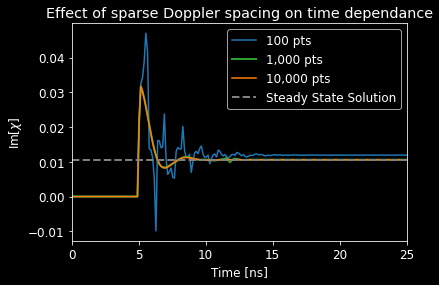

In [13]:
# H_ss = -(Det-Dops[k])*s11 -Wr*(s12+s21) 
# chi_ss = np.trapz(get_chi2lev(Det-Dops,Rabi=Wr,prefactor = 1, Gamma = G)*Pd,Dops)


fig,ax = plt.subplots()
ax.plot(t_1e2,chi_1e2,label='100 pts',color = 'tab:blue')
ax.plot(t_1e3,chi_1e3,label='1,000 pts',color = 'tab:green',lw=2)
ax.plot(t_1e4,chi_1e4,label='10,000 pts',color = 'tab:orange')
ax.plot(t_1e2,np.ones(Nt)*np.imag(chi_ss),'--',lw = 2,color = 'gray',label = 'Steady State Solution')
ax.legend()

ax.set_xlim(0,25)
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Im[$\chi$]')
ax.set_title('Effect of sparse Doppler spacing on time dependance')

# fig.savefig('../../Notes/Images/2023/time_dep_dop_dense.png',bbox_inches = 'tight')